# Step 1: Data Preprocessing

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
# Load the dataset
anime_df = pd.read_csv(r"D:\Assignments Data Science ExcelR\Recommendation System\Recommendation System\anime.csv")

In [3]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
anime_df.columns

Index(['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members'], dtype='object')

In [5]:
anime_df.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


In [6]:
# Check for missing values
print(anime_df.isnull().sum())

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64


In [7]:
# Handle missing values
# For simplicity, we can drop rows with missing values for now
anime_df = anime_df.dropna()

In [8]:
# Verify that there are no more missing values
print(anime_df.isnull().sum())

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64


In [9]:
anime_df.describe()

,anime_id,rating,members
count,12017.000000,12017.000000,1.201700e+04
mean,13638.001165,6.478264,1.834888e+04
std,11231.076675,1.023857,5.537250e+04
min,1.000000,1.670000,1.200000e+01
25%,3391.000000,5.890000,2.250000e+02
50%,9959.000000,6.570000,1.552000e+03
75%,23729.000000,7.180000,9.588000e+03
max,34519.000000,10.000000,1.013917e+06


In [10]:
# Display unique values in categorical columns
print(anime_df['type'].unique())
print(anime_df['genre'].unique())

['Movie' 'TV' 'OVA' 'Special' 'Music' 'ONA']
['Drama, Romance, School, Supernatural'
 'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen'
 'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen' ...
 'Action, Comedy, Hentai, Romance, Supernatural' 'Hentai, Sports'
 'Hentai, Slice of Life']


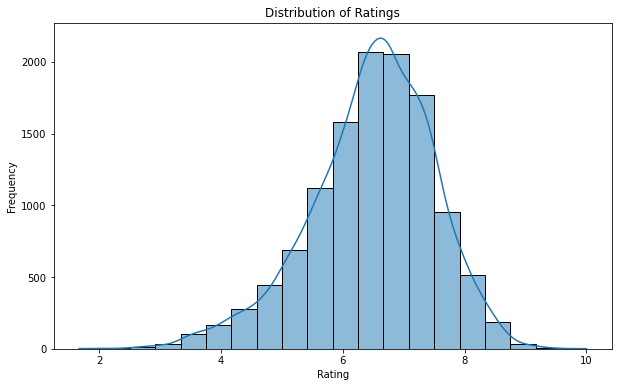

In [12]:
# Distribution of ratings
plt.figure(figsize=(10, 6))
sns.histplot(anime_df['rating'], bins=20, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

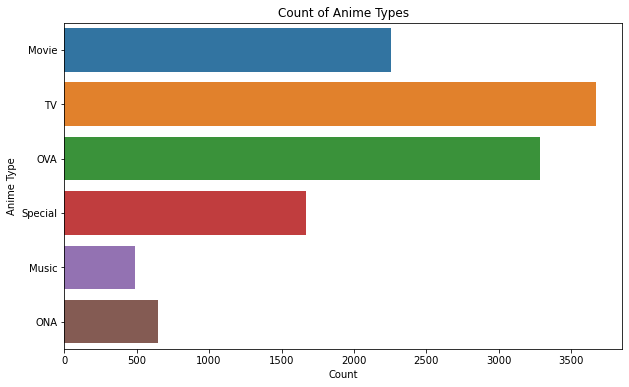

In [13]:
# Count plot of anime types
plt.figure(figsize=(10, 6))
sns.countplot(y=anime_df['type'])
plt.title('Count of Anime Types')
plt.xlabel('Count')
plt.ylabel('Anime Type')
plt.show()

In [14]:
# Count plot of genres (splitting and counting genres)
from collections import Counter

genres = anime_df['genre'].str.split(', ')
genres = genres.dropna()
genres_flat = [genre for sublist in genres for genre in sublist]
genre_counts = Counter(genres_flat)

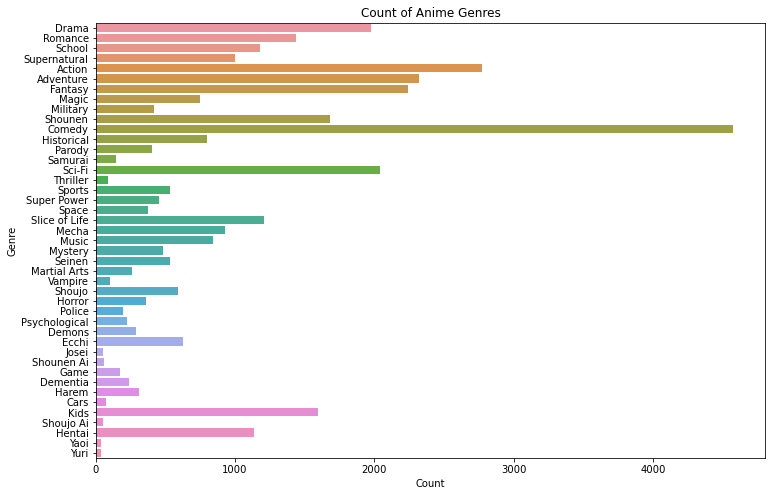

In [15]:
plt.figure(figsize=(12, 8))
sns.barplot(y=list(genre_counts.keys()), x=list(genre_counts.values()))
plt.title('Count of Anime Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

# Step 2: Feature Extraction

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

In [17]:
# Fill missing genres with empty string for TF-IDF processing
anime_df['genre'] = anime_df['genre'].fillna('')

In [18]:
# Convert genres to TF-IDF features
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(anime_df['genre'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=anime_df.index)

In [19]:
# Normalize ratings
scaler = MinMaxScaler()
anime_df['rating'] = anime_df['rating'].fillna(anime_df['rating'].mean())
anime_df['rating'] = scaler.fit_transform(anime_df[['rating']])

In [20]:
# Combine features: TF-IDF for genres and normalized ratings
features_df = pd.concat([tfidf_df, anime_df[['rating']]], axis=1)

In [21]:
# Compute cosine similarity matrix
cosine_sim = cosine_similarity(features_df, features_df)

# Step 3: Recommendation System

In [37]:
# Function to get recommendations
def get_recommendations(name, num_recommendations=10, similarity_threshold=0.1):
    if name not in anime_df['name'].values:
        return []
    
    idx = anime_df[anime_df['name'] == name].index
    if len(idx) == 0:
        return []
    
    idx = idx[0]
    
    # Ensure index is within bounds
    if idx >= cosine_sim.shape[0]:
        print(f"Index {idx} is out of bounds.")
        return []
    
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = [score for score in sim_scores if score[1] >= similarity_threshold]
    sim_scores = sim_scores[1:num_recommendations + 1]
    anime_indices = [i[0] for i in sim_scores]
    
    return anime_df['name'].iloc[anime_indices].tolist()


In [38]:
 #Example usage with different thresholds
print("Recommendations for 'Naruto' with default settings:")
print(get_recommendations('Naruto'))

print("\nRecommendations for 'Naruto' with a higher similarity threshold:")
print(get_recommendations('Naruto', similarity_threshold=0.2))

print("\nRecommendations for 'Naruto' with fewer recommendations:")
print(get_recommendations('Naruto', num_recommendations=5))

Recommendations for 'Naruto' with default settings:
['Naruto: Shippuuden', 'Boruto: Naruto the Movie - Naruto ga Hokage ni Natta Hi', 'Boruto: Naruto the Movie', 'Naruto x UT', 'Naruto: Shippuuden Movie 4 - The Lost Tower', 'Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsugu Mono', 'Naruto Shippuuden: Sunny Side Battle', 'Naruto Soyokazeden Movie: Naruto to Mashin to Mitsu no Onegai Dattebayo!!', 'Naruto: Shippuuden Movie 6 - Road to Ninja', 'Rekka no Honoo']

Recommendations for 'Naruto' with a higher similarity threshold:
['Naruto: Shippuuden', 'Boruto: Naruto the Movie - Naruto ga Hokage ni Natta Hi', 'Boruto: Naruto the Movie', 'Naruto x UT', 'Naruto: Shippuuden Movie 4 - The Lost Tower', 'Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsugu Mono', 'Naruto Shippuuden: Sunny Side Battle', 'Naruto Soyokazeden Movie: Naruto to Mashin to Mitsu no Onegai Dattebayo!!', 'Naruto: Shippuuden Movie 6 - Road to Ninja', 'Rekka no Honoo']

Recommendations for 'Naruto' with fewer recommendations:
['Na

# Step 4: Evaluation

In [28]:
# Evaluation metrics functions
def precision_at_k(recommended, relevant, k):
    recommended_at_k = recommended[:k]
    relevant_at_k = len(set(recommended_at_k) & set(relevant))
    return relevant_at_k / k if k > 0 else 0

def recall_at_k(recommended, relevant, k):
    recommended_at_k = recommended[:k]
    relevant_at_k = len(set(recommended_at_k) & set(relevant))
    return relevant_at_k / len(relevant) if len(relevant) > 0 else 0

def f1_score_at_k(precision, recall):
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)


In [29]:
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(anime_df, test_size=0.2, random_state=42)

In [34]:
# Evaluate the system
k = 10  # Number of recommendations to evaluate

precisions = []
recalls = []
f1_scores = []

for _, row in test_df.iterrows():
    name = row['name']
    relevant = [name]
    
    recommended = get_recommendations(name, num_recommendations=k)
    
    if not recommended:
        continue
    
    precision = precision_at_k(recommended, relevant, k)
    recall = recall_at_k(recommended, relevant, k)
    f1 = f1_score_at_k(precision, recall)
    
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

average_precision = np.mean(precisions)
average_recall = np.mean(recalls)
average_f1_score = np.mean(f1_scores)

print(f'Average Precision at {k}: {average_precision}')
print(f'Average Recall at {k}: {average_recall}')
print(f'Average F1 Score at {k}: {average_f1_score}')

Index 12057 is out of bounds.
Index 12052 is out of bounds.
Index 12048 is out of bounds.
Index 12209 is out of bounds.
Index 12117 is out of bounds.
Index 12225 is out of bounds.
Index 12084 is out of bounds.
Index 12060 is out of bounds.
Index 12292 is out of bounds.
Index 12083 is out of bounds.
Index 12119 is out of bounds.
Index 12172 is out of bounds.
Index 12184 is out of bounds.
Index 12103 is out of bounds.
Index 12287 is out of bounds.
Index 12207 is out of bounds.
Index 12028 is out of bounds.
Index 12180 is out of bounds.
Index 12120 is out of bounds.
Index 12132 is out of bounds.
Index 12188 is out of bounds.
Index 12088 is out of bounds.
Index 12056 is out of bounds.
Index 12077 is out of bounds.
Index 12163 is out of bounds.
Index 12243 is out of bounds.
Index 12241 is out of bounds.
Index 12189 is out of bounds.
Index 12064 is out of bounds.
Index 12118 is out of bounds.
Index 12191 is out of bounds.
Index 12247 is out of bounds.
Index 12240 is out of bounds.
Index 1218

# Interview Questions:

Q1. Can you explain the difference between user-based and item-based collaborative filtering?

User-Based Collaborative Filtering: Recommends items based on the preferences of similar users.

Item-Based Collaborative Filtering: Recommends items based on the similarity between items.

Both methods can be effective depending on the context and the nature of the data available. In practice, hybrid approaches that combine user-based and item-based filtering are often used to leverage the strengths of both methods.

Q2. What is collaborative filtering, and how does it work?

Collaborative filtering is a technique used in recommendation systems to suggest items to users based on the preferences and behaviors of other users. It relies on the idea that users who have agreed in the past will agree in the future. Collaborative filtering can be broadly classified into two main types: user-based and item-based.

How Collaborative Filtering Works:

1. Data Collection
2. Similarity Computation
3. Recommendation Generation